In [153]:
import pandas as pd
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from global_land_mask import globe

import numpy as np
from sklearn.model_selection import train_test_split

In [154]:
#Helper functions

def depth_zone(d: float) -> str:
    """
    Classify the input as one of "Epipelagic", "Mesopelagic", "Bathypelagic"
    
    Input:
        d: float
            depth of sea, between 0 and 2000
    Return:
        zone: str
            one of "Epipelagic", "Mesopelagic", and "Bathypelagic"
    """
    if 0 <= d <= 200:
        return "Epipelagic"
    elif 200 < d <= 1000:
        return "Mesopelagic"
    else:
        return "Bathypelagic"
    
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(dat: dt.datetime) -> str:
    """
    Returns the season of a particular date
    
    Input:
        date: datetime
            a date
    Return:
        season: str
    """
    if isinstance(dat, dt.datetime):
        dat = dat.date()
    dat = dat.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dat <= end)

In [155]:
def fetch_data(start_time: str, end_time: str, attribute: str,
               min_lon: float = -180, max_lon: float = 180, 
               min_lat: float = -90, max_lat: float = 90, 
               min_dep: float = 0, max_dep: float = 2000, ) -> pd.DataFrame:
    """
    Fetch Argo data using the API, with the specified locations, 
    time frame, depth, and attributes.
    
    Inputs:
        start_time, end_time: str, required
            the desired time frame. Should be in format 'yyyy-mm-dd'
        attribute: str, required
            The desired type of attributes from one of 'salinity' or 'temp'.
        min_lon, max_lon: float
            the desired range of longitudes between -180 and 180
        min_lat, max_lat: float
            the desired range of latitudes between -90 and 90
        min_depth, max_depth: float
            the desired depth between 0 and 2000
    
    Return:
        result: pd.DataFrame
            A data frame containing float no., season, location, depth (m), depth zone, 
            temp/salinity
    """
    
    #Check input
    assert -180 <= min_lon <= max_lon <= 180, "Please enter valid min_lon or max_lon" 
    assert -90 <= min_lat <= max_lat <= 90, "Please enter valid min_lat or max_lat" 
    assert 0 <= min_dep <= max_dep <= 2000, "Please enter valid min_dep or max_dep" 
    
    try:
        dt.datetime.strptime(start_time, "%Y-%m-%d")
        dt.datetime.strptime(end_time, "%Y-%m-%d")
    except:
        raise Exception("Please enter a valid start_time or end_time.")
        
    assert attribute in ["salinity", "temp"]
    
    #Fetch data from Argo API and store in xarr as an xarray
    reg = [min_lon, max_lon, min_lat, max_lat, min_dep, max_dep, start_time, end_time]
    # print("Downloading data from Argo...")
    xarr = ArgoDataFetcher().region(reg).to_xarray()
    columns = ["PRES", "PSAL", "TEMP", "LATITUDE", "LONGITUDE", "TIME", "DATA_MODE", \
               "POSITION_QC", "PRES_QC", "PSAL_QC", "TEMP_QC"]
    df = xarr.to_dataframe()[columns]
    
    #TODO: Check there are enough points. How many points should we aim for?
    
    #Subset QC'ed data
    idx = (df['DATA_MODE'] == 'D') & (df['POSITION_QC'] == 1) & \
      (df['PRES_QC'] == 1) & (df['PSAL_QC'] == 1) & (df['TEMP_QC'] == 1)
    df = df[idx]
    df = df.reset_index(drop = True)
    
    #Classify based on depth
    df["Depth Zone"] = df["PRES"].apply(depth_zone)
    
    #Classify based on season
    df["Season"] = df["TIME"].apply(get_season)
    
    #Get the desired attributes
    if attribute == "salinity":
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "PSAL"]]
    else:
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "TEMP"]]
    
    return df

In [156]:
def clean_data(data, var = 'TEMP'):
    data = data.loc[data['Depth Zone'] == 'Mesopelagic']
    avg_data = data.groupby(['LATITUDE', 'LONGITUDE'])[var].mean().reset_index()
    X = avg_data[['LATITUDE', 'LONGITUDE']].to_numpy()
    y = avg_data[var].to_numpy()
    return X, y

In [157]:
def get_cartesian(lat=None, lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z

# https://gis.stackexchange.com/questions/298619/mercator-map-coordinates-transformation-formula
def mercator(lonlat, R = 6378137.0):
    lon, lat = lonlat[:,0], lonlat[:, 1]
    x = R * np.radians(lon)
    y = R * np.log(
        np.tan((np.pi * 0.25) + (0.5 * np.radians(lat))))
    return np.array((x, y)).T

In [158]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Data from 2012

### Temperature

In [159]:
data_2012_09 = fetch_data('2012-09-01', '2012-09-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [160]:
data_2012_10 = fetch_data('2012-10-01', '2012-10-31', 'temp', -60, -40, 50, 65, 0, 2000)

In [161]:
data_2012_11 = fetch_data('2012-11-01', '2012-11-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [162]:
X_2012_09, y_2012_09 = clean_data(data_2012_09)
X_2012_10, y_2012_10 = clean_data(data_2012_10)
X_2012_11, y_2012_11 = clean_data(data_2012_11)

X_2012 = np.vstack([X_2012_09, X_2012_10, X_2012_11])
y_2012 = np.hstack([y_2012_09, y_2012_10, y_2012_11])

np.save('tmp/X_2012.npy', X_2012)
np.save('tmp/y_2012.npy', y_2012)

### Salinity

In [163]:
data_2012_09 = fetch_data('2012-09-01', '2012-09-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [164]:
data_2012_10 = fetch_data('2012-10-01', '2012-10-31', 'salinity', -60, -40, 50, 65, 0, 2000)

In [165]:
data_2012_11 = fetch_data('2012-11-01', '2012-11-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [166]:
X_2012_09, y_2012_09 = clean_data(data_2012_09, var = 'PSAL')
X_2012_10, y_2012_10 = clean_data(data_2012_10, var = 'PSAL')
X_2012_11, y_2012_11 = clean_data(data_2012_11, var = 'PSAL')

X_2012 = np.vstack([X_2012_09, X_2012_10, X_2012_11])
y_2012 = np.hstack([y_2012_09, y_2012_10, y_2012_11])

np.save('sal/X_2012.npy', X_2012)
np.save('sal/y_2012.npy', y_2012)

## Data from 2018 - 2020

### Temperature

#### 2018

In [113]:
data_2018_09 = fetch_data('2018-09-01', '2018-09-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [114]:
data_2018_10 = fetch_data('2018-10-01', '2018-10-31', 'temp', -60, -40, 50, 65, 0, 2000)

In [115]:
data_2018_11 = fetch_data('2018-11-01', '2018-11-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [116]:
X_2018_09, y_2018_09 = clean_data(data_2018_09)
X_2018_10, y_2018_10 = clean_data(data_2018_10)
X_2018_11, y_2018_11 = clean_data(data_2018_11)

X_2018 = np.vstack([X_2018_09, X_2018_10, X_2018_11])
y_2018 = np.hstack([y_2018_09, y_2018_10, y_2018_11])

np.save('tmp/X_2018.npy', X_2018)
np.save('tmp/y_2018.npy', y_2018)

#### 2019

In [136]:
data_2019_09 = fetch_data('2019-09-01', '2019-09-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [137]:
data_2019_10 = fetch_data('2019-10-01', '2019-10-31', 'temp', -60, -40, 50, 65, 0, 2000)

In [138]:
data_2019_11 = fetch_data('2019-11-01', '2019-11-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [139]:
X_2019_09, y_2019_09 = clean_data(data_2019_09)
X_2019_10, y_2019_10 = clean_data(data_2019_10)
X_2019_11, y_2019_11 = clean_data(data_2019_11)

X_2019 = np.vstack([X_2019_09, X_2019_10, X_2019_11])
y_2019 = np.hstack([y_2019_09, y_2019_10, y_2019_11])

np.save('tmp/X_2019.npy', X_2019)
np.save('tmp/y_2019.npy', y_2019)

#### 2020

In [140]:
data_2020_09 = fetch_data('2020-09-01', '2020-09-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [141]:
data_2020_10 = fetch_data('2020-10-01', '2020-10-31', 'temp', -60, -40, 50, 65, 0, 2000)

In [143]:
data_2020_11 = fetch_data('2020-11-01', '2020-11-30', 'temp', -60, -40, 50, 65, 0, 2000)

In [146]:
X_2020_09, y_2020_09 = clean_data(data_2020_09)
X_2020_10, y_2020_10 = clean_data(data_2020_10)
X_2020_11, y_2020_11 = clean_data(data_2020_11)

X_2020 = np.vstack([X_2020_09, X_2020_10, X_2020_11])
y_2020 = np.hstack([y_2020_09, y_2020_10, y_2020_11])

np.save('tmp/X_2020.npy', X_2020)
np.save('tmp/y_2020.npy', y_2020)

#### Combine

In [147]:
X_curr = np.vstack([X_2018, X_2019, X_2020])
y_curr = np.hstack([y_2018, y_2019, y_2020])

In [148]:
np.save('tmp/X_curr.npy', X_curr)
np.save('tmp/y_curr.npy', y_curr)

### Salinity

#### 2018

In [124]:
data_2018_09 = fetch_data('2018-09-01', '2018-09-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [125]:
data_2018_10 = fetch_data('2018-10-01', '2018-10-31', 'salinity', -60, -40, 50, 65, 0, 2000)

In [126]:
data_2018_11 = fetch_data('2018-11-01', '2018-11-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [127]:
min(data_2018_09['PSAL']), max(data_2018_09['PSAL'])

(32.15700149536133, 35.98099899291992)

In [128]:
X_2018_09, y_2018_09 = clean_data(data_2018_09, var = 'PSAL')
X_2018_10, y_2018_10 = clean_data(data_2018_10, var = 'PSAL')
X_2018_11, y_2018_11 = clean_data(data_2018_11, var = 'PSAL')

X_2018 = np.vstack([X_2018_09, X_2018_10, X_2018_11])
y_2018 = np.hstack([y_2018_09, y_2018_10, y_2018_11])

np.save('sal/X_2018.npy', X_2018)
np.save('sal/y_2018.npy', y_2018)

#### 2019

In [137]:
data_09 = fetch_data('2019-09-01', '2019-09-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [138]:
data_10 = fetch_data('2019-10-01', '2019-10-31', 'salinity', -60, -40, 50, 65, 0, 2000)

In [139]:
data_11 = fetch_data('2019-11-01', '2019-11-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [140]:
X_09, y_09 = clean_data(data_09, var = 'PSAL')
X_10, y_10 = clean_data(data_10, var = 'PSAL')
X_11, y_11 = clean_data(data_11, var = 'PSAL')

X_2019 = np.vstack([X_09, X_10, X_11])
y_2019 = np.hstack([y_09, y_10, y_11])

np.save('sal/X_2019.npy', X_2019)
np.save('sal/y_2019.npy', y_2019)

#### 2020

In [141]:
data_09 = fetch_data('2020-09-01', '2020-09-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [142]:
data_10 = fetch_data('2020-10-01', '2020-10-31', 'salinity', -60, -40, 50, 65, 0, 2000)

In [143]:
data_11 = fetch_data('2020-11-01', '2020-11-30', 'salinity', -60, -40, 50, 65, 0, 2000)

In [144]:
X_09, y_09 = clean_data(data_09, var = 'PSAL')
X_10, y_10 = clean_data(data_10, var = 'PSAL')
X_11, y_11 = clean_data(data_11, var = 'PSAL')

X_2020 = np.vstack([X_09, X_10, X_11])
y_2020 = np.hstack([y_09, y_10, y_11])

np.save('sal/X_2020.npy', X_2020)
np.save('sal/y_2020.npy', y_2020)

#### Combine

In [148]:
X_cur = np.vstack([X_2018, X_2019, X_2020])
y_cur = np.hstack([y_2018, y_2019, y_2020])

In [149]:
np.save('sal/X_cur.npy', X_cur)
np.save('sal/y_cur.npy', y_cur)

## Data from 1999 - 2005

#### Temperature

In [ ]:
data_1999 = fetch_data('1999-09-01', '1999-11-30', 'temp', -60, 40, 50, 65, 0, 2000)
data_2000 = fetch_data('2000-09-01', '2000-11-30', 'temp', -60, 40, 50, 65, 0, 2000)
data_2001 = fetch_data('2001-09-01', '2001-11-30', 'temp', -60, 40, 50, 65, 0, 2000)
data_2002 = fetch_data('2002-09-01', '2002-11-30', 'temp', -60, 40, 50, 65, 0, 2000)
data_2003 = fetch_data('2003-09-01', '2003-11-30', 'temp', -60, 40, 50, 65, 0, 2000)
data_2004 = fetch_data('2004-09-01', '2004-11-30', 'temp', -60, 40, 50, 65, 0, 2000)
data_2005 = fetch_data('2005-09-01', '2005-11-30', 'temp', -60, 40, 50, 65, 0, 2000)

In [ ]:
X_1999, y_1999 = clean_data(data_1999)
X_2000, y_2000 = clean_data(data_2000)
X_2001, y_2001 = clean_data(data_2001)
X_2002, y_2002 = clean_data(data_2002)
X_2003, y_2003 = clean_data(data_2003)
X_2004, y_2004 = clean_data(data_2004)
X_2005, y_2005 = clean_data(data_2005)

In [ ]:
X_old = np.vstack([X_1999, X_2000, X_2001, X_2002, X_2003, X_2004, X_2005])
y_old = np.hstack([y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005])
np.save('tmp/X_old.npy', X_old)
np.save('tmp/y_old.npy', y_old)

#### Salinity

In [150]:
data_1999 = fetch_data('1999-09-01', '1999-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)
data_2000 = fetch_data('2000-09-01', '2000-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)
data_2001 = fetch_data('2001-09-01', '2001-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)
data_2002 = fetch_data('2002-09-01', '2002-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)
data_2003 = fetch_data('2003-09-01', '2003-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)
data_2004 = fetch_data('2004-09-01', '2004-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)
data_2005 = fetch_data('2005-09-01', '2005-11-30', 'salinity', -60, 40, 50, 65, 0, 2000)

In [151]:
X_1999, y_1999 = clean_data(data_1999, var = 'PSAL')
X_2000, y_2000 = clean_data(data_2000, var = 'PSAL')
X_2001, y_2001 = clean_data(data_2001, var = 'PSAL')
X_2002, y_2002 = clean_data(data_2002, var = 'PSAL')
X_2003, y_2003 = clean_data(data_2003, var = 'PSAL')
X_2004, y_2004 = clean_data(data_2004, var = 'PSAL')
X_2005, y_2005 = clean_data(data_2005, var = 'PSAL')

In [152]:
X_old = np.vstack([X_1999, X_2000, X_2001, X_2002, X_2003, X_2004, X_2005])
y_old = np.hstack([y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005])
np.save('sal/X_old.npy', X_old)
np.save('sal/y_old.npy', y_old)

## Data Visualization

In [ ]:
X_curr = np.load('X_curr.npy')
y_curr = np.load('y_curr.npy')

In [ ]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines(resolution='auto', color='k')
ax.gridlines(color='lightgrey', linestyle='-', draw_labels=True)
ax.coastlines()
ax.stock_img()

ax.scatter(X_curr[:, 1], X_curr[:, 0], s = 1, c = y_curr, transform = ccrs.PlateCarree(), cmap = 'coolwarm')
ax.set_extent([-60, -10, 46, 73], crs=ccrs.PlateCarree())
plt.show()
#plt.colorbar(ax = ax)

## Gaussian Process Regression

In [12]:
X_curr = np.load('../Data/X_curr.npy')
y_curr = np.load('../Data/y_curr.npy')

idx = (X_curr[:, 1] >= -60) & (X_curr[:, 1] <= -40) & (X_curr[:, 0] >= 50) & (X_curr[:, 0] <= 65)
X_curr = mercator(X_curr[idx])
y_curr = y_curr[idx]

X_trn, X_tst, y_trn, y_tst = train_test_split(X_curr, y_curr, random_state = 666, test_size = 0.25)

In [13]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel
#kernel = 1.0 * RBF(length_scale = 10000)

In [14]:
%%time
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr.fit(X_trn, y_trn) 

CPU times: user 4.13 s, sys: 540 ms, total: 4.67 s
Wall time: 4.77 s


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [99]:
lat_span = np.linspace(50, 65, 401)
lon_span = np.linspace(-60, -40, 401)

lat, lon = np.meshgrid(lat_span, lon_span)
lonlat = np.vstack([lat.ravel(), lon.ravel()]).T
idx = ~globe.is_land(lonlat[:, 0], lonlat[:, 1])
pts = mercator(lonlat)

In [100]:
y_hat, std = gpr.predict(pts, return_std = True)

In [ ]:
np.mean((gpr.predict(X_trn) - y_trn)**2)

9.091347806720262e-05

In [89]:
np.mean(gpr.predict(X_tst) - y_tst)**2

0.11455347682779723

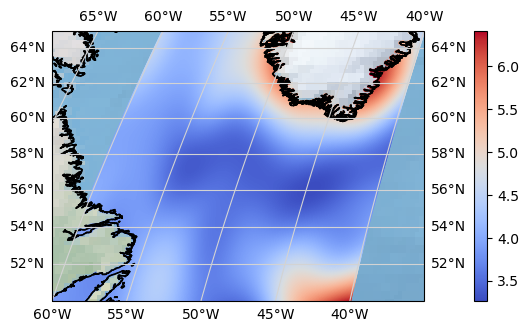

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()
ax.stock_img()

ct = ax.scatter(lonlat[:, 1][idx], lonlat[:, 0][idx], c = y_pred[idx], s = 1, cmap = 'coolwarm', transform = ccrs.PlateCarree())
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.73, pad = 0.1)
plt.savefig('curr_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

### Confidence Interval

In [73]:
lat_span = np.linspace(50, 65, 101)
lon_span = np.linspace(-60, -40, 101)

lat, lon = np.meshgrid(lat_span, lon_span)
pts = np.vstack([lat.ravel(), lon.ravel()]).T
idx = ~globe.is_land(pts[:, 0], pts[:, 1])
pts = pts[idx]
mrc = mercator(pts)

In [35]:
%%time
y_hat = gpr.predict(pts)

CPU times: user 594 ms, sys: 52 ms, total: 646 ms
Wall time: 659 ms


In [36]:
%%time
y_smp = gpr.sample_y(pts, 100)

CPU times: user 6min 35s, sys: 2.78 s, total: 6min 38s
Wall time: 6min 40s


In [39]:
np.save('y_smp.npy', y_smp)

In [38]:
lower = np.percentile(y_smp, 2.5, axis = 1)
upper = np.percentile(y_smp, 97.5, axis = 1)

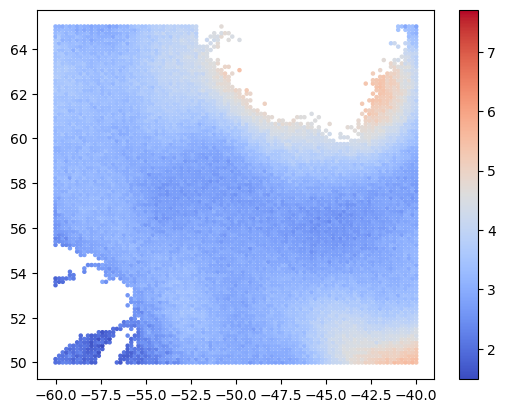

In [80]:
plt.scatter(pts[:, 1], pts[:, 0], c = lower, s = 5, cmap = 'coolwarm', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.savefig('lower.png')

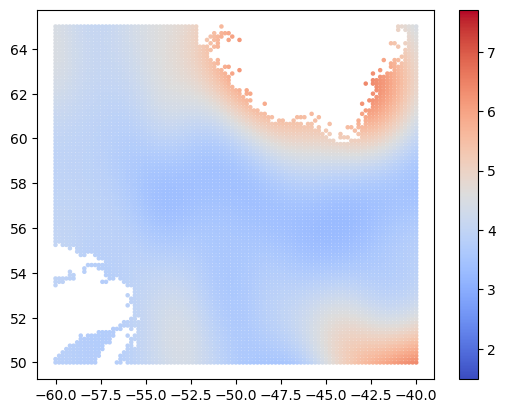

In [81]:
plt.scatter(pts[:, 1], pts[:, 0], c = y_hat, s = 5, cmap = 'coolwarm', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.savefig('middle.png')

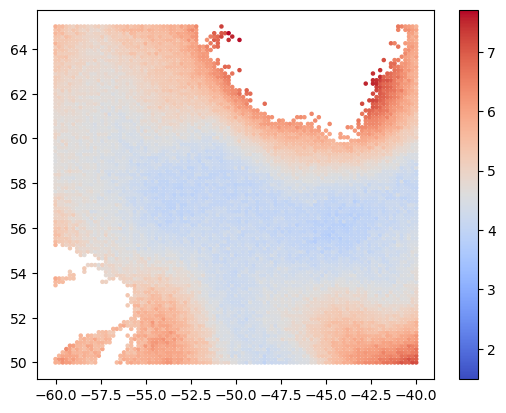

In [82]:
plt.scatter(pts[:, 1], pts[:, 0], c = upper, s = 5, cmap = 'coolwarm', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.savefig('upper.png')

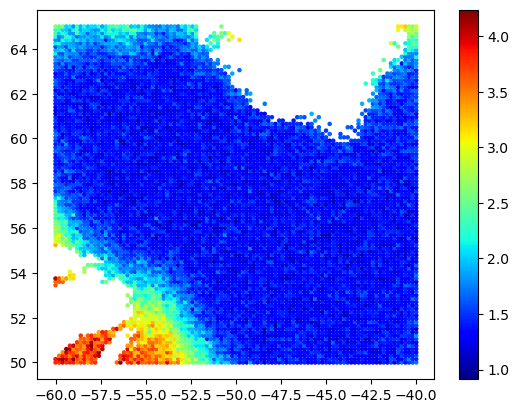

In [83]:
plt.scatter(pts[:, 1], pts[:, 0], c = upper - lower, s = 5, cmap = 'jet')
plt.colorbar()
plt.savefig('length.png')

## RBF Interpolation

In [ ]:
from scipy.interpolate import RBFInterpolator

### 2018 - 2020

In [ ]:
X_curr = mercator(np.load('tmp/X_curr.npy'))
y_curr = np.load('tmp/y_curr.npy')

X_trn, X_tst, y_trn, y_tst = train_test_split(X_curr, y_curr, random_state = 666, test_size = 0.25)

In [ ]:
smoothings = 10**np.linspace(8, 14, 101)
errs = np.array([])
for s in smoothings:
    f_hat = RBFInterpolator(X_trn, y_trn, smoothing = s)
    y_hat = f_hat(X_tst)
    errs = np.append(errs, (np.mean((y_hat - y_tst)**2)))
    print(np.log10(s), '\t', errs[-1])

In [ ]:
plt.plot(smoothings, errs)
plt.gca().set_xscale("log", base=10)

In [ ]:
s_curr = smoothings[errs == np.min(errs)][0]

In [ ]:
f_curr = RBFInterpolator(X_curr, y_curr, smoothing = s_curr)

In [ ]:
lat_span = np.linspace(50, 65, 301)
lon_span = np.linspace(-60, -40, 301)

lat, lon = np.meshgrid(lat_span, lon_span)
pts = np.vstack([lat.ravel(), lon.ravel()]).T
pts = mercator(pts[~globe.is_land(pts[:, 0], pts[:, 1])])

zz_curr = f_curr(pts)

In [ ]:
min(zz_curr), max(zz_curr)

In [ ]:
plt.scatter(pts[:, 1], pts[:, 0], c = zz_curr, s = 1, cmap = 'coolwarm', vmin = 3, vmax = 9)
plt.colorbar()

### 1999 - 2005

In [ ]:
X_old = mercator(np.load('tmp/X_old.npy'))
y_old = np.load('tmp/y_old.npy')

X_trn, X_tst, y_trn, y_tst = train_test_split(X_old, y_old, random_state = 666, test_size = 0.25)

In [ ]:
smoothings = 10**np.linspace(8, 14, 101)
errs = np.array([])
for s in smoothings:
    f_hat = RBFInterpolator(X_trn, y_trn, smoothing = s)
    y_hat = f_hat(X_tst)
    errs = np.append(errs, (np.mean((y_hat - y_tst)**2)))
    print(np.log10(s), '\t', errs[-1])

In [ ]:
s_old

In [ ]:
s_curr

In [ ]:
plt.plot(smoothings, errs)
plt.gca().set_xscale("log", base=10)

In [ ]:
s_old = smoothings[errs == np.min(errs)][0]

In [ ]:
f_old = RBFInterpolator(X_old, y_old, smoothing = s_curr)

In [ ]:
lat_span = np.linspace(50, 65, 301)
lon_span = np.linspace(-60, -40, 301)

lat, lon = np.meshgrid(lat_span, lon_span)
pts = np.vstack([lat.ravel(), lon.ravel()]).T
pts = mercator(pts[~globe.is_land(pts[:, 0], pts[:, 1])])

zz_old = f_old(pts)

In [ ]:
plt.scatter(pts[:, 1], pts[:, 0], c = zz_old, s = 1, cmap = 'coolwarm', vmin = 3, vmax = 9)
plt.colorbar()